In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import cv2 as cv
import datetime
#from sklearn import metrics
from sklearn.utils import class_weight
from PIL import Image
##import time
import os
import torchvision
import torchsummary
from torch.utils.data import Dataset, DataLoader
#from IPython.display import Image, display

In [2]:
#from google.colab import userdata

#os.environ["GOOGLE_DRIVE_TOKEN"] = userdata.get('DRIVE_TOKEN')

In [3]:
#from google.colab import drive

# Montar Google Drive
#drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Guardar la variable de entorno para que no solicite autorización la próxima vez
#%env GOOGLE_DRIVE_MOUNT_POINT /content/drive

DEFINO EL SWEEP

In [4]:
sweep_config = {
    'method': 'random'
    }

In [5]:
metric = {
    'name': 'valid loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

In [6]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        }
    }

sweep_config['parameters'] = parameters_dict

In [7]:
parameters_dict.update({
    'epochs': {
        'value': 2}
    })

In [8]:
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': [0.0001],
        'max': [0.0001]
      },
    'batch_size': {'values': [64]
        # integers between 32 and 256
        # with evenly-distributed logarithms
        #'distribution': 'q_log_uniform_values',
        #'q': 4,
        #'min': 8,
        #'max': 64,
      }
    })

In [9]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'valid loss'},
 'parameters': {'batch_size': {'values': [64]},
                'epochs': {'value': 2},
                'learning_rate': {'distribution': 'uniform',
                                  'max': [0.0001],
                                  'min': [0.0001]},
                'optimizer': {'values': ['adam', 'sgd']}}}


INITIALISE THE SWEEP

In [10]:
#import wandb
#wandb.login()
#sweep_id = wandb.sweep(sweep_config, project="animal_img_classification")

In [11]:
import torchmetrics

In [12]:
# CARGO MODELO VGG19
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [13]:
# Creo un pipeline para transformar las imágenes.
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (200, 200)),
    torchvision.transforms.ToTensor()])

# Creo un pipeline para las transformaciones de augmentations.
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size = (200, 200)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomVerticalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size = (200, 200), scale = (0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation = 0.1, hue = 0.1),
                        torchvision.transforms.ToTensor()])

In [14]:
def trim_set(full_set, size):
    # Obtener el 10% del tamaño original de forma aleatoria
    desired_size = int(size * len(full_set))
    random_indices = random.sample(range(len(full_set)), desired_size)

    # Crear un nuevo conjunto de entrenamiento con las muestras seleccionadas
    random_subset = torch.utils.data.Subset(full_set, random_indices)

    return random_subset, random_indices

In [15]:
from torch.utils.data import Subset, random_split
from collections import defaultdict
import random

random.seed(42)

# Cargo imágenes de train, validación y test.
train_set = torchvision.datasets.ImageFolder(root = r'C:\Users\Leandro\CEIA_Analisis_de_datos\VPC2\TP\archive\animal_dataset\Remaining_train', transform = aug_data_transforms)
valid_set = torchvision.datasets.ImageFolder(root = r'C:\Users\Leandro\CEIA_Analisis_de_datos\VPC2\TP\archive\animal_dataset\Remaining_valid', transform = aug_data_transforms)
test_set = torchvision.datasets.ImageFolder(root = r'C:\Users\Leandro\CEIA_Analisis_de_datos\VPC2\TP\archive\animal_dataset\valid', transform = aug_data_transforms)

train_set, idx_train_set = trim_set(train_set, 1)
valid_set, idx_valid_set = trim_set(valid_set, 0.5)
test_set, idx_test_set = trim_set(test_set, 0.1)

# Obtén las clases únicas en el conjunto de datos
classes = test_set.dataset.classes

# Crea un diccionario para almacenar los índices de cada clase
class_indices = defaultdict(list)

# Almacena los índices de cada clase en el diccionario
for idx, (_, label) in enumerate(test_set.dataset.imgs):
    class_indices[label].append(idx)

# Selecciona aleatoriamente un elemento de cada clase
idx_test = [random.choice(class_indices[i]) for i,label in enumerate(classes)]

# Crea un nuevo conjunto de datos con los índices seleccionados
sample_test_set = Subset(test_set, idx_test)

train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_set, batch_size = 16, shuffle = False)
sample_test_loader = DataLoader(sample_test_set, batch_size = 10, shuffle = False)

In [16]:
#train_loader = sample_test_loader
#valid_loader = sample_test_loader
#test_loader = sample_test_loader

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
# Cargo modelo base
vgg19_model = torchvision.models.vgg19(weights = weights)

vgg19_model.to(device)

#torchsummary.summary(vgg19_model, input_size = (3, 200, 200))
#vgg19_model.modules

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [19]:
# Congelo capas de red base
for param in vgg19_model.parameters():
    param.requires_grad = False

# Agrego capa final
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features = 10)

In [20]:
labels = list(test_set.dataset.class_to_idx.keys())
print(labels)
#vgg19_model.classifier

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [21]:
from tqdm.auto import tqdm

# Determino vector de pesos para equilibrar el desbalance.
#labels_list = train_loader.dataset.targets
labels_list = np.array(train_loader.dataset.dataset.targets)[idx_train_set]

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.arange(10),
    y = np.array(labels_list))
class_weights = torch.tensor(class_weights, dtype = torch.float)

class_weights = class_weights.to(device)

class_weights

tensor([1.2383, 1.5694, 0.8445, 1.4097, 0.5381, 1.8105, 0.9978, 1.4380, 0.5429,
        1.4049], device='cuda:0')

In [22]:
criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

In [23]:
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'valid loss'},
 'parameters': {'batch_size': {'values': [64]},
                'epochs': {'value': 2},
                'learning_rate': {'distribution': 'uniform',
                                  'max': [0.0001],
                                  'min': [0.0001]},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [24]:
def log_data_augmentation():

  # SUBO IMÁGENES A WANDB PARA VISUALIZAR LOS DATA AUGMENTATIONS
  table = wandb.Table(columns=["Original", "Augmented"])

  # Convertir el tensor a una imagen PIL
  tensor_to_image = torchvision.transforms.ToPILImage()

  idxs = random.sample(list(range(1, len(train_set))), len(labels))

  for i,idx in enumerate(idxs):
    img_og = train_set[idx][0]
    img_mod = aug_data_transforms(tensor_to_image(img_og))

    table.add_data(wandb.Image(img_og), wandb.Image(img_mod))

  wandb.log({"augmented_table": table})

In [25]:
import wandb

In [26]:
with wandb.init(project='animal_image_classification'):
    model = vgg19_model
    artifact = wandb.use_artifact("img-classifier-v9rhc88r:v0")
    datadir = artifact.download()
    state_dict = torch.load(datadir + '\\model_1.pth')
    model.load_state_dict(state_dict)
    #path = artifact.get_entry("model_1.pth")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leandro-bello. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact img-classifier-v9rhc88r:v0, 532.59MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8


In [38]:
processed_image.shape

torch.Size([3, 200, 200])

{'butterfly': ' 0.00',
 'cat': ' 1.00',
 'chicken': ' 0.00',
 'cow': ' 0.00',
 'dog': ' 0.00',
 'elephant': ' 0.00',
 'horse': ' 0.00',
 'sheep': ' 0.00',
 'spider': ' 0.00',
 'squirrel': ' 0.00'}


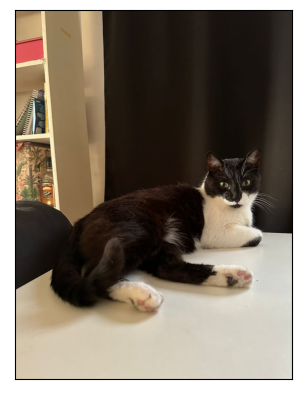

In [56]:
inference_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size = (200, 200)),
                    torchvision.transforms.ToTensor()])

image_path = r"C:\Users\Leandro\Downloads\WhatsApp Image 2024-02-23 at 19.20.42.jpeg"
image = Image.open(image_path)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
processed_image = inference_transforms(image).unsqueeze(0).to(device)
model.to(device)
model.eval()
outputs = torch.softmax(model(processed_image), dim=1)[0]
prob_dict = {key:f'{value.item(): .2f}' for key,value in zip(labels, outputs)}
pprint.pprint(prob_dict)

In [33]:
state_dict = torch.load(datadir + '\\model_1.pth')
# Carga el state_dict en el modelo
model.load_state_dict(state_dict)

<All keys matched successfully>

In [30]:
from sklearn.metrics import recall_score
import copy

In [31]:
def train(config=None):
    global n, best_model, model, best_loss, epoch

    model = copy.deepcopy(vgg19_model)
    accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes = len(labels))
    model.to(device)
    accuracy_metric.to(device)

    # Initialize a new wandb run
    with wandb.init(config=config, name=f'run_{n}'):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        train_loader = build_batch(train_set, config.batch_size)
        optimizer, scheduler = build_optimizer(model, config.optimizer, config.learning_rate, train_loader, config.batch_size, config.epochs)
        current_lr = get_lr(optimizer)

        # LOG DATA AUGMENTATION
        log_data_augmentation()

        table = wandb.Table(columns=['Image', 'Label', 'Prediction', 'Right/Wrong', 'Probs'] + labels)

        for epoch in tqdm(range(config.epochs), desc="Epochs"):
            epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy, epoch_train_micro_recall, epoch_valid_micro_recall, model, train_data = train_epoch(train_loader, optimizer, scheduler, accuracy_metric)
            wandb.log({
                "train loss": epoch_train_loss,
                "train accuracy": epoch_train_accuracy,
                "train recall": epoch_train_micro_recall,
                "valid loss": epoch_valid_loss,
                "valid accuracy": epoch_valid_accuracy,
                "valid recall": epoch_valid_micro_recall,
                "learning rate": current_lr})

        is_best = epoch_valid_loss < best_loss
        best_loss = min(epoch_valid_loss, best_loss)

        # Save the model in the exchangeable ONNX format
        #torch.onnx.export(model, train_data, f"model_{n}.onnx")
        art = wandb.Artifact(f"img-classifier-{wandb.run.id}",
                            type = 'model',
                            metadata = {'format': 'onnx',
                                        'num_classes': len(labels),
                                        'model_type': 'vgg19'})

        #art.add_file(f"model_{n}.onnx")
        torch.save(model.state_dict(), f"model_{n}.pth")
        art.add_file(f"model_{n}.pth")

        # Add aliases to keep track of your best checkpoints over time
        wandb.log_artifact(art, aliases=["best", "latest"] if is_best else None)
        if is_best:
            best_model = art

        # CARGO EL CLASSIFICATION REPORT
        y_true = []
        y_pred = []
        for test_data, test_target in tqdm(test_loader, desc="Generating classification report"):
            test_data = test_data.to(device)
            test_target = list(test_target.to(device).detach().cpu().numpy())
            output = model(test_data)
            output = list(torch.argmax(output, dim=1).detach().cpu().numpy())
            y_true.extend(test_target)
            y_pred.extend(output)
        log_classification_report(y_true, y_pred, labels, n)

        # GENERO LOS GRADCAMS
        generate_grad_cam_images(model, test_loader)

        # CARGO LAS PREDICCIONES DE TEST
        for b, (test_data, test_target) in tqdm(enumerate(sample_test_loader), desc="Generating predictions"):
            test_data = test_data.to(device)
            test_target = test_target.to(device).detach().cpu().numpy()
            preds = model(test_data)
            probs = torch.softmax(preds, dim=1).detach().cpu().numpy()
            preds = torch.argmax(torch.softmax(preds, dim=1), dim=1).detach().cpu().numpy()
            for i, (label, pred) in enumerate(zip(test_target, preds)):
                true_label = labels[label.item()]
                guess_label = labels[pred.item()]
                transformacion_pil = torchvision.transforms.ToPILImage()
                img = transformacion_pil(test_data[i].detach().cpu())
                img.save(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/img_{i}.png")
                right_or_wrong = "right" if true_label == guess_label else "wrong"
                prob_dict = {label: prob for label, prob in zip(labels, probs[i])}
                table.add_data(wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/img_{i}.png"),
                               true_label,
                               guess_label,
                               right_or_wrong,
                               prob_dict,
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{0}).png"),
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{1}).png"),
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{2}).png"),
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{3}).png"),
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{4}).png"),
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{5}).png"),
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{6}).png"),
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{7}).png"),
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{8}).png"),
                               wandb.Image(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{9}).png"),)

        wandb.log({f"exp_{n}": table})
    n += 1

In [33]:
from sklearn.metrics import classification_report, accuracy_score

def log_classification_report(y_true, y_pred, labels, n):

    report_dict = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)

    data = pd.DataFrame(report_dict)
    data.insert(0, "METRIC", ['PRECISION', 'RECALL', 'F1-SCORE', 'SUPPORT'])
    data.columns = data.columns.astype(str)

    tabla = wandb.Table(
        dataframe=data,
        allow_mixed_types=True)

    wandb.log({f"classification_report_{n}": tabla})

In [40]:
def build_optimizer(model, optimizer, learning_rate, train_loader, batch_size, epochs):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(),
                               lr=learning_rate)

    total_steps = int(len(train_loader) * epochs)
    warmup_steps = max(int(total_steps * 0.1), 1)
    warmup_coef = 20

    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: warmup_linear_decay(step, warmup_steps, warmup_coef, total_steps, learning_rate, learning_rate * 0.01))
    return optimizer, scheduler

def build_batch(train_set, batch_size):
    train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
    return train_loader

def train_epoch(train_loader, optimizer, scheduler, accuracy_metric):

    global train_target, output

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    # Pongo el modelo en modo entrenamiento
    model.train()

    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0
    epoch_train_micro_recall = 0.0

    step = 1

    #for step, (train_data, train_target) in tqdm(enumerate(train_loader), desc="Training"):
    for train_data, train_target in tqdm(train_loader, desc="Training"):

        step_ = step + epoch * len(train_loader)

        train_data = train_data.to(device)
        train_target = train_target.to(device)

        optimizer.zero_grad()
        #current_lr = get_lr(optimizer)
        output = model(train_data)
        loss = criterion(output, train_target)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        output = torch.argmax(torch.softmax(output, dim=1), dim=1)

        accuracy = accuracy_metric(output, train_target).item()
        epoch_train_accuracy += accuracy
        micro_recall_train = recall_score(train_target.detach().cpu().numpy(), output.detach().cpu().numpy(), average='micro')
        epoch_train_micro_recall += micro_recall_train

        #wandb.log({
        #        "train loss": loss.item(),
        #        "train accuracy": accuracy,
        #        "train recall": micro_recall_train,
        #        "learning rate": current_lr}, step=step_)

        step += 1

    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
    epoch_train_micro_recall = epoch_train_micro_recall / len(train_loader)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_accuracy)

    # Pongo el modelo en modo evaluación
    model.eval()

    epoch_valid_loss = 0.0
    epoch_valid_accuracy = 0.0
    epoch_valid_micro_recall = 0.0

    for valid_data, valid_target in tqdm(valid_loader, desc="Validating"):

        valid_data = valid_data.to(device)
        valid_target = valid_target.to(device)

        output = model(valid_data)
        loss = criterion(output, valid_target)
        epoch_valid_loss += loss.item()

        output = torch.argmax(torch.softmax(output, dim=1), dim=1)

        accuracy = accuracy_metric(output, valid_target).item()
        epoch_valid_accuracy += accuracy
        micro_recall_valid = recall_score(valid_target.detach().cpu().numpy(), output.detach().cpu().numpy(), average='micro')
        epoch_valid_micro_recall += micro_recall_valid

    epoch_valid_loss = epoch_valid_loss / len(valid_loader)
    epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
    epoch_valid_micro_recall = epoch_valid_micro_recall / len(valid_loader)
    valid_loss.append(epoch_valid_loss)
    valid_acc.append(epoch_valid_accuracy)

    #if epoch == 0:
    #    wandb.log({
    #          "valid loss": epoch_valid_loss,
    #          "valid accuracy": epoch_valid_accuracy,
    #          "valid recall": epoch_valid_micro_recall}, step=1)

    #wandb.log({
    #        "valid loss": epoch_valid_loss,
    #        "valid accuracy": epoch_valid_accuracy,
    #        "valid recall": epoch_valid_micro_recall}, step=step_)

    return epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy, epoch_train_micro_recall, epoch_valid_micro_recall, model, train_data

In [41]:
from torch.optim import lr_scheduler

def get_lr(optimizer):
    lr = optimizer.param_groups[0]['lr']
    return lr

def warmup_linear_decay(current_step, warmup_steps, warmup_coef, total_steps, lr_init, lr_end):
    warmup_ratio = warmup_coef/warmup_steps
    if current_step <= warmup_steps:
        # Calentamiento lineal
        lr = lr_init + (1+warmup_ratio*current_step)
    else:
        # Decrecimiento lineal después del calentamiento
        peak = lr_init + (1+warmup_ratio*warmup_steps)
        ratio = (peak - lr_end)/(total_steps-warmup_steps)
        lr = peak - (current_step - warmup_steps) * ratio

    return max(lr, lr_end)

In [42]:
class Model(torch.nn.Module):
    def __init__(self, model):
        super(Model, self).__init__()

        # get the model network
        self.model = model

        # disect the network to access its last convolutional layer
        self.features_conv = torch.nn.Sequential(*list(self.model.children())[:-1])
        # self.features_conv = self.model.features[:36]

        # get the max pool of the features stem
        # self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg19
        self.classifier = self.model.classifier

        # placeholder for the gradients
        self.gradients = None

        for param in self.model.parameters():
            param.requires_grad = True

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):

        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        # x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

def generate_grad_cam_images(model, loader):

    model.to(device)
    model.eval()

    grad_model = Model(model)
    grad_model.eval()

    # load image to mix with heatmap
    for b, (test_data, test_target) in tqdm(enumerate(loader), desc='Generating grad cams'):

        test_data = test_data.to(device)
        test_target = test_target.to(device)

        # img shape
        batch_size, c, h, w = test_data.shape

        # aspect ratio
        aspect_ratio = h / w

        # make prediction
        #output = torch.argmax(probs, dim=1)

        for i in range(len(test_data)):
            for c in range(len(labels)):

                # get the most likely prediction of the model
                probs = torch.softmax(grad_model(test_data[i]), dim=1)

                # get the gradient of the output with respect to the parameters of the model
                probs[:, c].backward()

                # pull the gradients out of the model
                gradients = grad_model.get_activations_gradient()

                # pool the gradients across the channels
                pooled_gradients = torch.mean(gradients, dim=[1,2])

                # get the activations of the last convolutional layer
                activations = grad_model.get_activations(test_data[i]).detach()

                # weight the channels by corresponding gradients
                for k in range(512):
                    activations[k, :, :] *= pooled_gradients[k]

                # average the channels of the activations
                heatmap = torch.mean(activations, dim=0).cpu().numpy()

                # relu on top of the heatmap
                # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
                heatmap = np.maximum(heatmap, 1e-80)

                # normalize the heatmap
                max_value = np.max(heatmap)
                if max_value != 0:
                    heatmap /= max_value

                heatmap = cv.resize(heatmap, (test_data[i].shape[1], test_data[i].shape[2]))
                heatmap = np.uint8(255 * heatmap)
                heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
                heatmap = (np.transpose(heatmap, (2, 0, 1))/255).astype(np.float32)

                superimposed_img = cv.addWeighted(test_data[i].cpu().numpy(), 0.7, heatmap, 0.3, 0)
                superimposed_img = np.transpose(superimposed_img, (1, 2, 0))

                imagen_pil = Image.fromarray(np.uint8(superimposed_img*255))

                imagen_pil.save(f"C:/Users/Leandro/Desktop/Animal_classifier/GradCAM_imgs/grad_(batch-{b})_(img-{i})_(label-{c}).png")

In [43]:
#model = vgg19_model
#generate_grad_cam_images(model, sample_test_loader)

In [44]:
#from IPython.display import display
#
#for i in range(10):
#  imagen_pil = Image.open(f'/content/grad_(batch:0)_(img:0)_(label:{i}).png')
#  display(imagen_pil)

In [ ]:
n = 1
best_model = None
best_loss = np.inf
wandb.agent(sweep_id, train, count=10)

wandb: Agent Starting Run: vpu11fzr with config:
wandb: 	batch_size: 16
wandb: 	epochs: 2
wandb: 	learning_rate: 0.02381032417059511
wandb: 	optimizer: sgd


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Generating classification report:   0%|          | 0/49 [00:00<?, ?it/s]